In [1]:
pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ep9zc3ru
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ep9zc3ru
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 1.3 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33809 sha256=6d1f686ac233dfb73be7a335c36484e0f44bdabaafe437c0cbae899c5b0990b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxyj4djd/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [2]:
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, UpSampling3D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session


import numpy as np
from numpy import unravel_index
import pandas as pd

from os import listdir
import os, os.path

import glob

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage.measure
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score

from PIL import Image

import re
import gc

import time

In [3]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
0.0
1.0


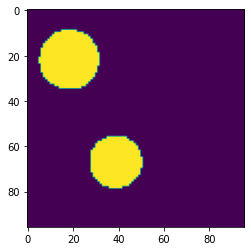

In [5]:
filepath = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Images96x96_newData(Normalized_maxpool_3D)'
imageDict = {}
for filename in os.listdir(filepath):
    path = os.path.join(filepath, filename)
    key = filename.split('.')[0]
    imageDict[key] = np.load(path,allow_pickle=True)
    print('Loaded: '+ key)
    print(imageDict[key].shape)


plt.imshow(imageDict['data_2_105_74'][70,:,:,0])
print(imageDict['data_2_105_74'][70].min())
print(imageDict['data_2_105_74'][70].max())

Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
-0.07724143392053406
4.328437686141806


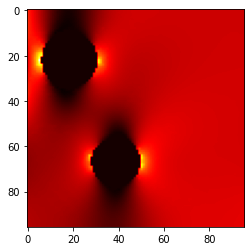

In [6]:
DIR = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Stress96x96_newData(Normalized_maxpool_3D)'
matrixDict = {}
for filename in os.listdir(DIR):
    path = os.path.join(DIR, filename)
    key = filename.split('.')[0]
    matrixDict[key] = np.load(path)
    print('Loaded: '+ key)
    print(matrixDict[key].shape)
    
plt.imshow(matrixDict['data_2_105_74'][70][:,:,0], cmap='hot')
print(matrixDict['data_2_105_74'][70].min())
print(matrixDict['data_2_105_74'][70].max())

In [7]:
# Combine X datas
x = np.concatenate((imageDict['data_2_105_74'], imageDict['data_2_115_65'],
                    imageDict['data_2_91_89'],imageDict['data_4_105_74'],imageDict['data_4_115_65'],
                    imageDict['data_4_91_89'], imageDict['data_6_91_89'], imageDict['data_6_105_74'],
                    imageDict['data_6_115_65'],), axis = 0)   
x.shape

(1800, 96, 96, 3)

In [8]:
# Combine Y datas 
y = np.concatenate((matrixDict['data_2_105_74'], matrixDict['data_2_115_65'],
                    matrixDict['data_2_91_89'],matrixDict['data_4_105_74'],matrixDict['data_4_115_65'],
                    matrixDict['data_4_91_89'], matrixDict['data_6_91_89'], matrixDict['data_6_105_74'],
                    matrixDict['data_6_115_65'],), axis = 0) 
y.shape

(1800, 96, 96, 3)

In [9]:
# Since there are total 1100 images,
# training data is 90% : 990
# testing data is 10% : 110
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1, 
                                                    random_state=42)

print('Shape of x_train',x_train.shape,'\n',
      'Shape of x_test',x_test.shape,'\n', 
      'Shape of y_train',y_train.shape,'\n', 
      'Shape of y_test',y_test.shape)

Shape of x_train (1620, 96, 96, 3) 
 Shape of x_test (180, 96, 96, 3) 
 Shape of y_train (1620, 96, 96, 3) 
 Shape of y_test (180, 96, 96, 3)


In [10]:
# For observing effects of data size, 

idx = np.random.randint(1620, size=100)
x_train_100 = x_train[idx,:,:,:]
y_train_100 = y_train[idx,:,:,:]
print('Shape of x_train_100',x_train_100.shape,'\n',
      'Shape of y_train_100',y_train_100.shape,'\n')

idx = np.random.randint(1620, size=300)
x_train_300 = x_train[idx,:,:,:]
y_train_300 = y_train[idx,:,:,:]
print('Shape of x_train_300',x_train_300.shape,'\n',
      'Shape of y_train_300',y_train_300.shape,'\n')

idx = np.random.randint(1620, size=500)
x_train_500 = x_train[idx,:,:,:]
y_train_500 = y_train[idx,:,:,:]
print('Shape of x_train_500',x_train_500.shape,'\n',
      'Shape of y_train_500',y_train_500.shape,'\n')

idx = np.random.randint(1620, size=700)
x_train_700 = x_train[idx,:,:,:]
y_train_700 = y_train[idx,:,:,:]
print('Shape of x_train_700',x_train_700.shape,'\n',
      'Shape of y_train_700',y_train_700.shape,'\n')

idx = np.random.randint(1620, size=900)
x_train_900 = x_train[idx,:,:,:]
y_train_900 = y_train[idx,:,:,:]
print('Shape of x_train_900',x_train_900.shape,'\n',
      'Shape of y_train_900',y_train_900.shape,'\n')

idx = np.random.randint(1620, size=1100)
x_train_1100 = x_train[idx,:,:,:]
y_train_1100 = y_train[idx,:,:,:]
print('Shape of x_train_1100',x_train_1100.shape,'\n',
      'Shape of y_train_1100',y_train_1100.shape,'\n')

idx = np.random.randint(1620, size=1300)
x_train_1300 = x_train[idx,:,:,:]
y_train_1300 = y_train[idx,:,:,:]
print('Shape of x_train_1300',x_train_1300.shape,'\n',
      'Shape of y_train_1300',y_train_1300.shape,'\n')

x_train_1620 = np.copy(x_train)
y_train_1620 = np.copy(y_train)
print('Shape of x_train_1620',x_train_1620.shape,'\n',
      'Shape of y_train_1620',y_train_1620.shape)

Shape of x_train_100 (100, 96, 96, 3) 
 Shape of y_train_100 (100, 96, 96, 3) 

Shape of x_train_300 (300, 96, 96, 3) 
 Shape of y_train_300 (300, 96, 96, 3) 

Shape of x_train_500 (500, 96, 96, 3) 
 Shape of y_train_500 (500, 96, 96, 3) 

Shape of x_train_700 (700, 96, 96, 3) 
 Shape of y_train_700 (700, 96, 96, 3) 

Shape of x_train_900 (900, 96, 96, 3) 
 Shape of y_train_900 (900, 96, 96, 3) 

Shape of x_train_1100 (1100, 96, 96, 3) 
 Shape of y_train_1100 (1100, 96, 96, 3) 

Shape of x_train_1300 (1300, 96, 96, 3) 
 Shape of y_train_1300 (1300, 96, 96, 3) 

Shape of x_train_1620 (1620, 96, 96, 3) 
 Shape of y_train_1620 (1620, 96, 96, 3)


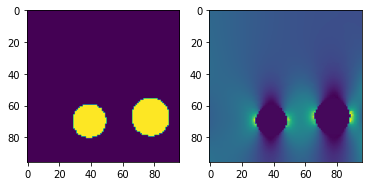

[[[1.60180774 1.60180774 1.60180774]
  [1.59735764 1.59735764 1.59735764]
  [1.5928533  1.5928533  1.5928533 ]
  ...
  [1.59805145 1.59805145 1.59805145]
  [1.66791374 1.66791374 1.66791374]
  [1.73780019 1.73780019 1.73780019]]

 [[1.60299529 1.60299529 1.60299529]
  [1.59842885 1.59842885 1.59842885]
  [1.59380818 1.59380818 1.59380818]
  ...
  [1.59651629 1.59651629 1.59651629]
  [1.66619688 1.66619688 1.66619688]
  [1.73590163 1.73590163 1.73590163]]

 [[1.58903645 1.58903645 1.58903645]
  [1.58886337 1.58886337 1.58886337]
  [1.58863607 1.58863607 1.58863607]
  ...
  [1.60940192 1.60940192 1.60940192]
  [1.6889093  1.6889093  1.6889093 ]
  [1.76844085 1.76844085 1.76844085]]

 ...

 [[2.82154936 2.82154936 2.82154936]
  [2.61369875 2.61369875 2.61369875]
  [2.41445202 2.41445202 2.41445202]
  ...
  [1.35901858 1.35901858 1.35901858]
  [1.39708622 1.39708622 1.39708622]
  [1.42979329 1.42979329 1.42979329]]

 [[2.81440377 2.81440377 2.81440377]
  [2.60801959 2.60801959 2.60801959]


In [11]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train_100[71][:,:,0])
f.add_subplot(1,2, 2)
plt.imshow(y_train_100[71][:,:,0])
plt.show(block=True)
print(y_train_100[70])

In [12]:
# A function calculating Percentage Error
def percentage_err_3channels(y_pred, y_test):
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            for z in range(y_test.shape[3]):
                if(0 in y_test[idx]):
                    continue
                else:
                    err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                    arr.append(err)
    
    return abs(np.mean(arr))

# A function calculating Percentage Error with 1-channel
def percentage_err_1channel(y_pred, y_test): 
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            if(0 in y_test[idx,x,:]):
                continue
            else:
                err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                arr.append(err)
    
    return np.mean(arr)

# A Function to calculate R2 for each pore
def calculateR2_for_pores(preds, y_test, AVMat):
    b = []
    c = []
    TSS = 0
    RSS = 0
    
    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b
        
    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()
    
# A function to obtain AVMat
def calculateAVMat(y_test):
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])
    
    AVMat = AVMat/len(y_test)
    
    return AVMat

# A function calculates R2 score
def calculateR2(preds, y_test):
    b = []
    c = []
    TSS = 0
    RSS = 0
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])

    AVMat = AVMat/len(y_test)

    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b

    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()

# A function calculates MSE
def calculateMSE(dataA, dataB):
    errArray = []
    for i in range(len(dataA)):
        err = np.sum((dataA[i] - dataB[i]) ** 2)
        err /= float(dataA[i].shape[0] * dataA[i].shape[1])
        errArray.append(err)

    return sum(errArray) / len(errArray)

In [13]:
# Function reset the model
def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [14]:
# Setting training configuration
batch_size = 16 #originally 100
epochs = 100 #30 originally
AVMat = []
R2Array_train = []
R2Array_test = []
MSEArray_train = []
MSEArray_test = []
err_train_3ch = []
err_test_3ch = []
err_train_1ch = []
err_test_1ch = []

In [15]:
AVMat = calculateAVMat(y_train)

In [16]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [17]:
from keras_applications.resnet import preprocess_input
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE)
model.summary()

94592056/94592056 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

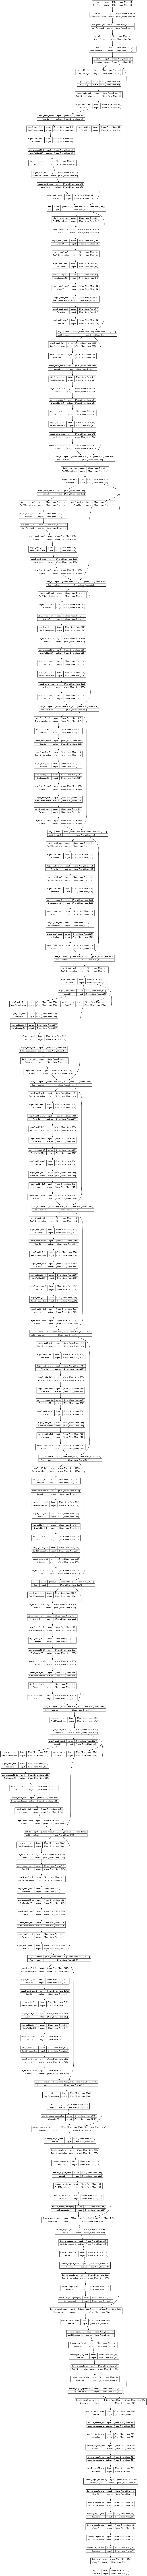

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [19]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [20]:
#Training with 100 data
%%time
model.fit(x_train_100, y_train_100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 18s 352ms/step - loss: 0.5954
Epoch 2/100
7/7 [==============================] - 1s 80ms/step - loss: 0.4136
Epoch 3/100
7/7 [==============================] - 1s 80ms/step - loss: 0.3607
Epoch 4/100
7/7 [==============================] - 1s 79ms/step - loss: 0.3361
Epoch 5/100
7/7 [==============================] - 1s 79ms/step - loss: 0.3213
Epoch 6/100
7/7 [==============================] - 1s 79ms/step - loss: 0.3138
Epoch 7/100
7/7 [==============================] - 1s 78ms/step - loss: 0.3087
Epoch 8/100
7/7 [==============================] - 1s 80ms/step - loss: 0.3048
Epoch 9/100
7/7 [==============================] - 1s 79ms/step - loss: 0.3025
Epoch 10/100
7/7 [==============================] - 1s 80ms/step - loss: 0.3005
Epoch 11/100
7/7 [==============================] - 1s 82ms/step - loss: 0.2990
Epoch 12/100
7/7 [==============================] - 1s 81ms/step - loss: 0.2985
Epoch 13/100
7/7 [=============================

In [21]:
%%time
preds_train = model.predict(x_train_100)
preds = model.predict(x_test)

6/6 [==============================] - 1s 216ms/step
CPU times: user 3.23 s, sys: 54.3 ms, total: 3.28 s
Wall time: 3.52 s


In [22]:
%%time
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

reset_keras(model)

[-0.16012253556876074]
[-0.1589801715912611]
65220
CPU times: user 1.53 s, sys: 124 ms, total: 1.66 s
Wall time: 1.74 s


In [23]:
#Train with 300 data points

model.fit(x_train_300, y_train_300, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
19/19 [==============================] - 5s 203ms/step - loss: 0.2821
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.2807
Epoch 3/100
19/19 [==============================] - 2s 88ms/step - loss: 0.2800
Epoch 4/100
19/19 [==============================] - 2s 88ms/step - loss: 0.2796
Epoch 5/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2794
Epoch 6/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2793
Epoch 7/100
19/19 [==============================] - 2s 90ms/step - loss: 0.2794
Epoch 8/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2793
Epoch 9/100
19/19 [==============================] - 2s 90ms/step - loss: 0.2792
Epoch 10/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2792
Epoch 11/100
19/19 [==============================] - 2s 90ms/step - loss: 0.2789
Epoch 12/100
19/19 [==============================] - 2s 90ms/step - loss: 0.2787
Epoch 13/100
19/19 [====

In [24]:
%%time
preds_train = model.predict(x_train_300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 1.06 s, sys: 20 ms, total: 1.08 s
Wall time: 1.07 s


In [25]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_300))
MSEArray_test.append(calculateMSE(preds, y_test))

In [26]:
print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367]
[-0.1589801715912611, 0.20793299059758116]


In [27]:
#Train with 500 data points

model.fit(x_train_500, y_train_500, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
32/32 [==============================] - 3s 93ms/step - loss: 0.2914
Epoch 2/100
32/32 [==============================] - 3s 92ms/step - loss: 0.2910
Epoch 3/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2902
Epoch 4/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2900
Epoch 5/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2897
Epoch 6/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2897
Epoch 7/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2895
Epoch 8/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2895
Epoch 9/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2893
Epoch 10/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2894
Epoch 11/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2892
Epoch 12/100
32/32 [==============================] - 3s 91ms/step - loss: 0.2890
Epoch 13/100
32/32 [=====

In [28]:
%%time
preds_train = model.predict(x_train_500)
preds = model.predict(x_test)

6/6 [==============================] - 0s 36ms/step
CPU times: user 1.04 s, sys: 27.3 ms, total: 1.07 s
Wall time: 1.63 s


In [29]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_500))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_500))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_500))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684]


In [30]:
#Train with 700 data points

model.fit(x_train_700, y_train_700, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
44/44 [==============================] - 4s 92ms/step - loss: 0.2770
Epoch 2/100
44/44 [==============================] - 4s 91ms/step - loss: 0.2767
Epoch 3/100
44/44 [==============================] - 4s 92ms/step - loss: 0.2761
Epoch 4/100
44/44 [==============================] - 4s 92ms/step - loss: 0.2758
Epoch 5/100
44/44 [==============================] - 4s 93ms/step - loss: 0.2757
Epoch 6/100
44/44 [==============================] - 4s 93ms/step - loss: 0.2756
Epoch 7/100
44/44 [==============================] - 4s 93ms/step - loss: 0.2755
Epoch 8/100
44/44 [==============================] - 4s 94ms/step - loss: 0.2756
Epoch 9/100
44/44 [==============================] - 4s 95ms/step - loss: 0.2754
Epoch 10/100
44/44 [==============================] - 4s 93ms/step - loss: 0.2752
Epoch 11/100
44/44 [==============================] - 4s 93ms/step - loss: 0.2751
Epoch 12/100
44/44 [==============================] - 4s 92ms/step - loss: 0.2750
Epoch 13/100
44/44 [=====

In [31]:
%%time
preds_train = model.predict(x_train_700)
preds = model.predict(x_test)

6/6 [==============================] - 0s 36ms/step
CPU times: user 2.31 s, sys: 34.8 ms, total: 2.34 s
Wall time: 2.4 s


In [32]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_700))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_700))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_700))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708, 0.21270612558404403]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684, 0.21019355384749516]


In [33]:
#Train with 900 data points

model.fit(x_train_900, y_train_900, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2780
Epoch 2/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2777
Epoch 3/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2774
Epoch 4/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2773
Epoch 5/100
57/57 [==============================] - 5s 92ms/step - loss: 0.2770
Epoch 6/100
57/57 [==============================] - 5s 92ms/step - loss: 0.2769
Epoch 7/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2767
Epoch 8/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2766
Epoch 9/100
57/57 [==============================] - 5s 93ms/step - loss: 0.2766
Epoch 10/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2765
Epoch 11/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2765
Epoch 12/100
57/57 [==============================] - 5s 91ms/step - loss: 0.2764
Epoch 13/100
57/57 [=====

In [34]:
%%time
preds_train = model.predict(x_train_900)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 1.59 s, sys: 43.3 ms, total: 1.63 s
Wall time: 1.57 s


In [35]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_900))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_900))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_900))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708, 0.21270612558404403, 0.22639033309393156]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684, 0.21019355384749516, 0.21059332547725637]


In [36]:
#Train with 1100 data points

model.fit(x_train_1100, y_train_1100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2807
Epoch 2/100
69/69 [==============================] - 6s 91ms/step - loss: 0.2803
Epoch 3/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2799
Epoch 4/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2798
Epoch 5/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2796
Epoch 6/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2795
Epoch 7/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2794
Epoch 8/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2794
Epoch 9/100
69/69 [==============================] - 6s 94ms/step - loss: 0.2793
Epoch 10/100
69/69 [==============================] - 6s 93ms/step - loss: 0.2792
Epoch 11/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2793
Epoch 12/100
69/69 [==============================] - 6s 92ms/step - loss: 0.2793
Epoch 13/100
69/69 [=====

In [37]:
%%time
preds_train = model.predict(x_train_1100)
preds = model.predict(x_test)

6/6 [==============================] - 0s 36ms/step
CPU times: user 1.8 s, sys: 30.8 ms, total: 1.83 s
Wall time: 1.77 s


In [38]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708, 0.21270612558404403, 0.22639033309393156, 0.2296202034438849]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684, 0.21019355384749516, 0.21059332547725637, 0.2109493557788271]


In [39]:
#Train with 1300 data points

model.fit(x_train_1300, y_train_1300, 
          batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
82/82 [==============================] - 8s 91ms/step - loss: 0.2738
Epoch 2/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2736
Epoch 3/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2734
Epoch 4/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2732
Epoch 5/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2731
Epoch 6/100
82/82 [==============================] - 7s 91ms/step - loss: 0.2730
Epoch 7/100
82/82 [==============================] - 7s 91ms/step - loss: 0.2729
Epoch 8/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2729
Epoch 9/100
82/82 [==============================] - 8s 93ms/step - loss: 0.2729
Epoch 10/100
82/82 [==============================] - 8s 92ms/step - loss: 0.2728
Epoch 11/100
82/82 [==============================] - 7s 91ms/step - loss: 0.2728
Epoch 12/100
82/82 [==============================] - 7s 91ms/step - loss: 0.2728
Epoch 13/100
82/82 [=====

In [40]:
%%time
preds_train = model.predict(x_train_1300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 36ms/step
CPU times: user 2.05 s, sys: 37.1 ms, total: 2.09 s
Wall time: 2.03 s


In [41]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1300))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708, 0.21270612558404403, 0.22639033309393156, 0.2296202034438849, 0.22584766460556244]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684, 0.21019355384749516, 0.21059332547725637, 0.2109493557788271, 0.21070325735650766]


In [42]:
#Train with 1620 data points

model.fit(x_train_1620, y_train_1620, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
102/102 [==============================] - 9s 91ms/step - loss: 0.2779
Epoch 2/100
102/102 [==============================] - 9s 92ms/step - loss: 0.2777
Epoch 3/100
102/102 [==============================] - 9s 93ms/step - loss: 0.2775
Epoch 4/100
102/102 [==============================] - 9s 93ms/step - loss: 0.2773
Epoch 5/100
102/102 [==============================] - 10s 93ms/step - loss: 0.2772
Epoch 6/100
102/102 [==============================] - 9s 92ms/step - loss: 0.2771
Epoch 7/100
102/102 [==============================] - 9s 92ms/step - loss: 0.2771
Epoch 8/100
102/102 [==============================] - 9s 91ms/step - loss: 0.2770
Epoch 9/100
102/102 [==============================] - 9s 91ms/step - loss: 0.2770
Epoch 10/100
102/102 [==============================] - 9s 91ms/step - loss: 0.2770
Epoch 11/100
102/102 [==============================] - 9s 92ms/step - loss: 0.2770
Epoch 12/100
102/102 [==============================] - 9s 92ms/step - loss: 0.2769


In [43]:
%%time
preds_train = model.predict(x_train_1620)
preds = model.predict(x_test)

6/6 [==============================] - 0s 36ms/step
CPU times: user 2.51 s, sys: 90.5 ms, total: 2.6 s
Wall time: 2.62 s


In [44]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1620))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1620))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1620))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[-0.16012253556876074, 0.21014926202740367, 0.20600801540621708, 0.21270612558404403, 0.22639033309393156, 0.2296202034438849, 0.22584766460556244, 0.22648109442493528]
[-0.1589801715912611, 0.20793299059758116, 0.20921657293361684, 0.21019355384749516, 0.21059332547725637, 0.2109493557788271, 0.21070325735650766, 0.21054484683986918]
